In [14]:
import matplotlib.pyplot as plt
import seaborn as sns
import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout , BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
from keras.callbacks import ReduceLROnPlateau
import cv2
import os
import numpy as np
# from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
# from tensorflow.keras.layers import Conv2D, MaxPooling2D

<h2> Data Loading </h2> <br>
<i> Initially we define a function that loads and resizes to 150 x 150 pixels every image for every
    subset. Since the images are variable in size, a resizing is deemed necessary and for complexity
    purposes, we have decided to opt for the aforementioned resolution.
</i>

In [5]:
labels = ['PNEUMONIA', 'NORMAL']
img_size = 100

def get_data(data_dir):
    data = [] 
    img_avg_pixels = 0
    img_cnt = 0
    for label in labels: 
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
                resized_arr = cv2.resize(img_arr, (img_size, img_size)) # Reshaping images to preferred size
                data.append([resized_arr, class_num])
            except Exception as e:
                print(e)
    return [np.array(data), img_avg_pixels]

In [6]:
train = get_data('datasets/archive/chest_xray/chest_xray/train')
test = get_data('datasets/archive/chest_xray/chest_xray/test')
val = get_data('datasets/archive/chest_xray/chest_xray/val')

OpenCV(4.5.2) /tmp/pip-req-build-13uokl4r/opencv/modules/imgproc/src/resize.cpp:4051: error: (-215:Assertion failed) !ssize.empty() in function 'resize'

OpenCV(4.5.2) /tmp/pip-req-build-13uokl4r/opencv/modules/imgproc/src/resize.cpp:4051: error: (-215:Assertion failed) !ssize.empty() in function 'resize'



<ipython-input-5-1bc2df956b54>:18: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return [np.array(data), img_avg_pixels]


OpenCV(4.5.2) /tmp/pip-req-build-13uokl4r/opencv/modules/imgproc/src/resize.cpp:4051: error: (-215:Assertion failed) !ssize.empty() in function 'resize'

OpenCV(4.5.2) /tmp/pip-req-build-13uokl4r/opencv/modules/imgproc/src/resize.cpp:4051: error: (-215:Assertion failed) !ssize.empty() in function 'resize'



<h2> Data Preprocessing </h2> <br>
<i> After loading the resized images, we create our training, testing and validataion datasets along with
    their respective labels. <br></i>
    <b>Pneumonia => 0</b><br>
    <b>Normal => 1</b><br>


In [7]:
train = train[0]
test = test[0]
val = val[0]

x_train = []
y_train = []

x_val = []
y_val = []

x_test = []
y_test = []

for feature, label in train:
    x_train.append(feature)
    y_train.append(label)

for feature, label in test:
    x_test.append(feature)
    y_test.append(label)
    
for feature, label in val:
    x_val.append(feature)
    y_val.append(label)

In [8]:
# NORMALIZE IMAGE PIXELS
x_train = np.array(x_train) / 255
x_val = np.array(x_val) / 255
x_test = np.array(x_test) / 255

# RESIZE DATA FOR DEEP LEARNING
x_train = x_train.reshape(-1, img_size, img_size, 1)
y_train = np.array(y_train)

x_val = x_val.reshape(-1, img_size, img_size, 1)
y_val = np.array(y_val)

x_test = x_test.reshape(-1, img_size, img_size, 1)
y_test = np.array(y_test)


<h2> Image augmentation </h2><br>
<i> Create an image generator which will create a balanced batch size during each
    Neural Network epoch. The images generated will differ slightly, in order to prevent
    overfitting, with the usage of techniques like image flipping, zooming and rotating.</i>

In [9]:
datagen = ImageDataGenerator(
          rotation_range = 30,  # randomly rotate image. val = Degree range for random rotations.
          zoom_range = 0.2, # Float or [lower, upper]. Range for random zoom. If a float, [lower, upper] = [1-zoom_range, 1+zoom_range].
          width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
          height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
          horizontal_flip = True)  # randomly flip images

datagen.fit(x_train)

<h2> Model Layers </h2>
<b>1) Conv2D</b> <br>
    <i>This layer creates a convolution kernel that is convolved with the layer input to produce a tensor of outputs. </i><br>
<b>2) MaxPool2D</b> <br> 
<i>Downsamples the input along its spatial dimensions (height and width) by taking the maximum value over an input window (of size defined by pool_size) for each channel of the input. The window is shifted by strides along each dimension. </i><br>
<b>3) Dropout</b> <br>
<i>The Dropout layer randomly sets input units to 0 with a frequency of rate at each step during training time, which helps prevent overfitting. Inputs not set to 0 are scaled up by 1/(1 - rate) such that the sum over all inputs is unchanged. </i><br>
<b>4) Flatten</b> <br>
<i>Flattens the input. Does not affect the batch size. <br> E.g. (1, 10, 64) => (640)  </i><br>
<b>5) Dense</b> <br>
<i>Just your regular densely-connected NN layer. </i><br>

<h2> Speed up CNN </h2>
<i>Before we dive deeper into the topic, there’s a more stable way to factorize big kernels: just stack smaller ones instead. For example, instead of using 5x5 convolutions, stack two 3x3 ones, or 3 if you want to substitute a 7x7 kernel. For more information see [4].</i>

<h2> Callbacks </h2>
<b> 1) monitor</b>: quantity to be monitored. <br>
<b>    2) factor</b>: factor by which the learning rate will be reduced. new_lr = lr * factor.<br>
<b>    3) patience</b>: number of epochs with no improvement after which learning rate will be reduced.<br>
<b>    4) verbose</b>: int. 0: quiet, 1: update messages.<br>
<b>    5) mode</b>: one of {'auto', 'min', 'max'}. In 'min' mode, the learning rate will be reduced when the quantity monitored has stopped decreasing; in 'max' mode it will be reduced when the quantity monitored has stopped increasing; in 'auto' mode, the direction is automatically inferred from the name of the monitored quantity.<br>
<b>    6) min_delta</b>: threshold for measuring the new optimum, to only focus on significant changes.<br>
<b>    7) cooldown</b>: number of epochs to wait before resuming normal operation after lr has been reduced.<br>
<b>    8) min_lr</b>: lower bound on the learning rate.<br>

In [19]:
epochs = 12

model = Sequential()

model.add(Conv2D(32 , (3,3), strides = 1, padding = 'same', activation = 'relu', input_shape = (img_size, img_size, 1)))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Conv2D(64 , (3,3), strides = 1, padding = 'same', activation = 'relu'))
model.add(BatchNormalization())
model.add(Dropout(0.1))
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Conv2D(64 , (3,3), strides = 1, padding = 'same', activation = 'relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Conv2D(128 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))

model.add(Flatten())  

model.add(Dense(128, activation = 'relu'))
model.add(Dropout(0.2))
model.add(Dense(units = 1 , activation = 'sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['binary_accuracy'])
display(model.summary())

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_17 (Conv2D)           (None, 100, 100, 32)      320       
_________________________________________________________________
batch_normalization_17 (Batc (None, 100, 100, 32)      128       
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 50, 50, 32)        0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 50, 50, 64)        18496     
_________________________________________________________________
batch_normalization_18 (Batc (None, 50, 50, 64)        256       
_________________________________________________________________
dropout_12 (Dropout)         (None, 50, 50, 64)        0         
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 25, 25, 64)       

None

In [20]:
callback = ReduceLROnPlateau(
        monitor='val_binary_accuracy', #MONITOR ACCURACY 
        factor=0.2,
        verbose = 2,
        patience=2, 
        min_lr=0.0000001)
model_var = model.fit(
    datagen.flow(x_train,y_train, batch_size = 32), 
    epochs=epochs, 
    validation_data = datagen.flow(x_val, y_val),
    callbacks = callback)

Epoch 1/12
163/163 [==============================] - 52s 315ms/step - loss: 0.7175 - binary_accuracy: 0.8030 - val_loss: 16.3172 - val_binary_accuracy: 0.5000
Epoch 2/12
163/163 [==============================] - 50s 306ms/step - loss: 0.2750 - binary_accuracy: 0.8934 - val_loss: 32.6416 - val_binary_accuracy: 0.5000
Epoch 3/12
163/163 [==============================] - 53s 325ms/step - loss: 0.2355 - binary_accuracy: 0.9151 - val_loss: 22.1127 - val_binary_accuracy: 0.5000

Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
Epoch 4/12
163/163 [==============================] - 53s 323ms/step - loss: 0.1492 - binary_accuracy: 0.9455 - val_loss: 4.8188 - val_binary_accuracy: 0.5625
Epoch 5/12
163/163 [==============================] - 52s 318ms/step - loss: 0.1531 - binary_accuracy: 0.9482 - val_loss: 6.0003 - val_binary_accuracy: 0.5000
Epoch 6/12
163/163 [==============================] - 50s 309ms/step - loss: 0.1528 - binary_accuracy: 0.9530 - val_loss

In [21]:
print("Loss: " , model.evaluate(x_test,y_test)[0])
print("Accuracy: " , model.evaluate(x_test,y_test)[1]*100 , "%")

20/20 [==============================] - 1s 61ms/step - loss: 0.2586 - binary_accuracy: 0.9215
Loss:  0.25858068466186523
20/20 [==============================] - 2s 75ms/step - loss: 0.2586 - binary_accuracy: 0.9215
Accuracy:  92.14743375778198 %


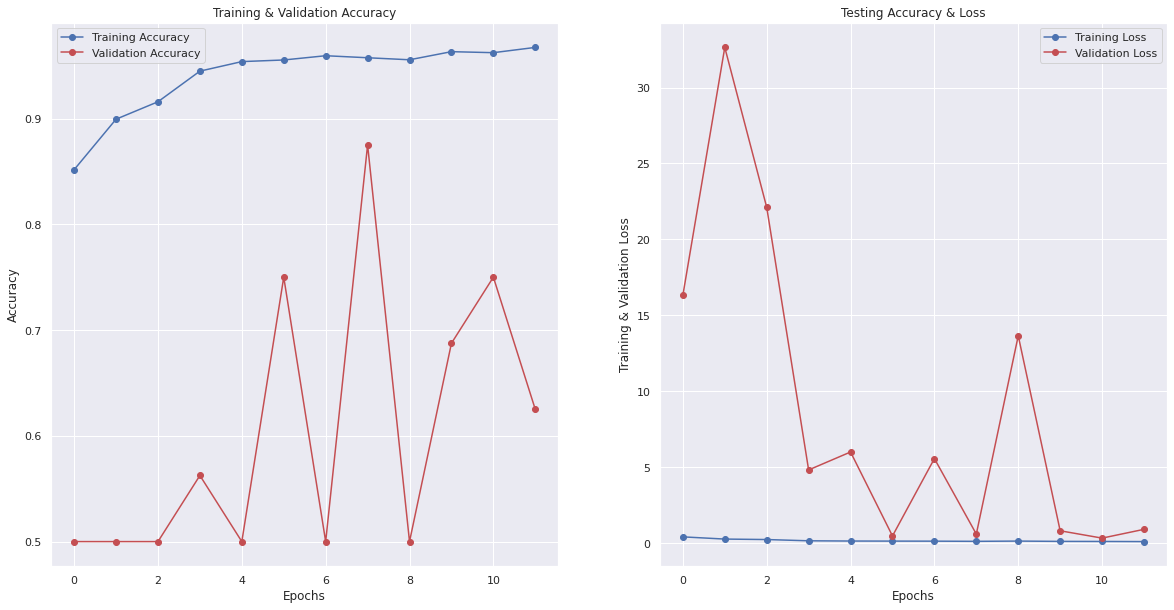

In [25]:
sns.set()
# epochs = [i for i in range(epochs)]
fig , ax = plt.subplots(1,2)
train_acc = model_var.history['binary_accuracy'] #accuracy
train_loss = model_var.history['loss']
val_acc = model_var.history['val_binary_accuracy'] # val_accuracy
val_loss = model_var.history['val_loss']
fig.set_size_inches(20,10)

ax[0].plot(epochs , train_acc , 'bo-' , label = 'Training Accuracy')
ax[0].plot(epochs , val_acc , 'ro-' , label = 'Validation Accuracy')
ax[0].set_title('Training & Validation Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs , train_loss , 'b-o' , label = 'Training Loss')
ax[1].plot(epochs , val_loss , 'r-o' , label = 'Validation Loss')
ax[1].set_title('Testing Accuracy & Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Training & Validation Loss")
plt.show()

In [26]:
predictions = model.predict_classes(x_test)
predictions = predictions.reshape(1,-1)[0]

/usr/local/lib/python3.8/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


                     precision    recall  f1-score   support

Pneumonia (Class 0)       0.92      0.95      0.94       390
   Normal (Class 1)       0.92      0.87      0.89       234

           accuracy                           0.92       624
          macro avg       0.92      0.91      0.92       624
       weighted avg       0.92      0.92      0.92       624



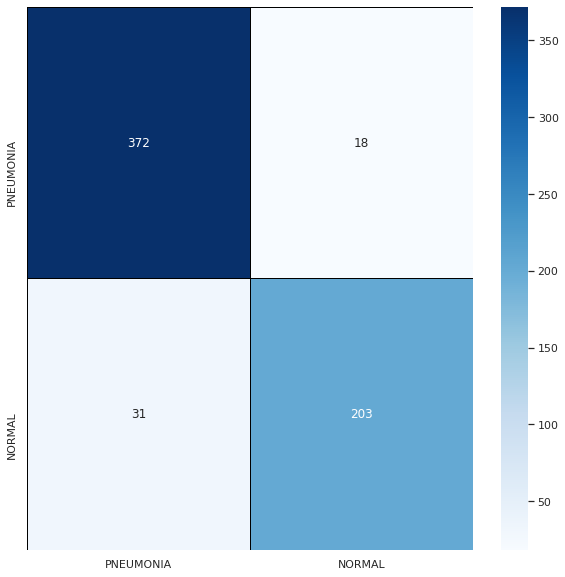

In [63]:
print(classification_report(y_test, predictions, target_names = ['Pneumonia (Class 0)','Normal (Class 1)']))
cm = confusion_matrix(y_test,predictions)
plt.figure(figsize = (10,10))
sns.heatmap(
    cm,cmap= "Blues", 
    linecolor = 'black' , 
    linewidth = 1 , 
    annot = True, 
    fmt='',
    xticklabels = labels,
    yticklabels = labels)
plt.show()

In [56]:
correct = np.nonzero(predictions == y_test)[0]
incorrect = np.nonzero(predictions != y_test)[0]

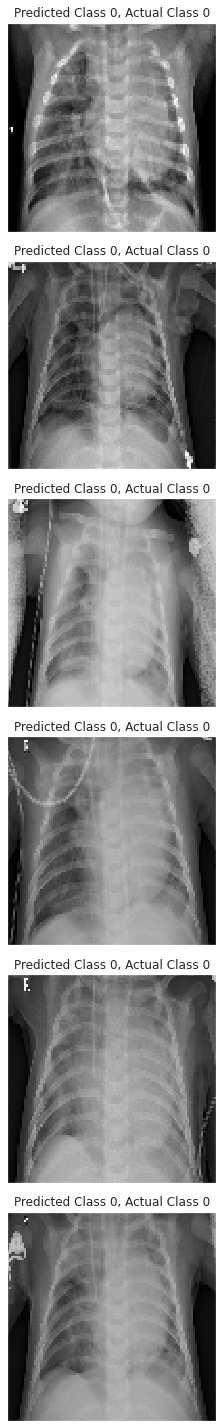

In [58]:
i = 0
sns.set()
plt.figure(figsize=(20,20))
for c in correct[:6]:
    plt.subplot(6,1,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(x_test[c].reshape(100,100), cmap="gray", interpolation='none')
    plt.title("Predicted Class {}, Actual Class {}".format(predictions[c], y_test[c]))
    plt.tight_layout()
    i += 1

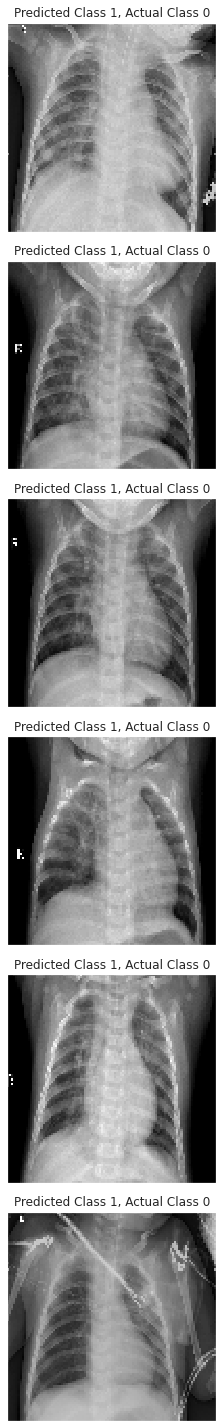

In [60]:
i = 0
sns.set()
plt.figure(figsize=(20,20))
for c in incorrect[:6]:
    plt.subplot(6,1,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(x_test[c].reshape(100,100), cmap="gray", interpolation='none')
    plt.title("Predicted Class {}, Actual Class {}".format(predictions[c], y_test[c]))
    plt.tight_layout()
    i += 1